## In this notebook, we use Care for pair wise training. Q1.
## CM02: Q0_o, Q1_o, Q2_o, Q3_o, Q4_o, Q4_i, Q3_i, Q2_i, Q1_i, Q0_i
## CM03: Q0_i, Q1_i, Q2_i, Q3_i, Q4_i, Q4_o, Q3_o, Q2_o, Q1_o, Q0_o

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import glob
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
import copy


Using TensorFlow backend.


## Load Input and Output Data 

In [2]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

10
Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the -14:-7  z-slices as input from CM02

In [3]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][-14:-7, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(7, 896, 576)


## Take only the 7:14 z-slices as output from CM02

In [4]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][7:14, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(7, 896, 576)


## Load images from CM03

In [5]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the 7:14 z-slices from CM03 as input

In [6]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][7:14, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(7, 896, 576)


## Take only the -14:-7 z-slices from CM03 as output

In [7]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][-14:-7, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(7, 896, 576)


## Combine X_CM02 and X_CM03

In [8]:
imgsX=X_CM02+X_CM03
print(len(imgsX))
print(imgsX[5].shape)

20
(7, 896, 576)


In [9]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(7, 896, 576)


## Visualize the images 

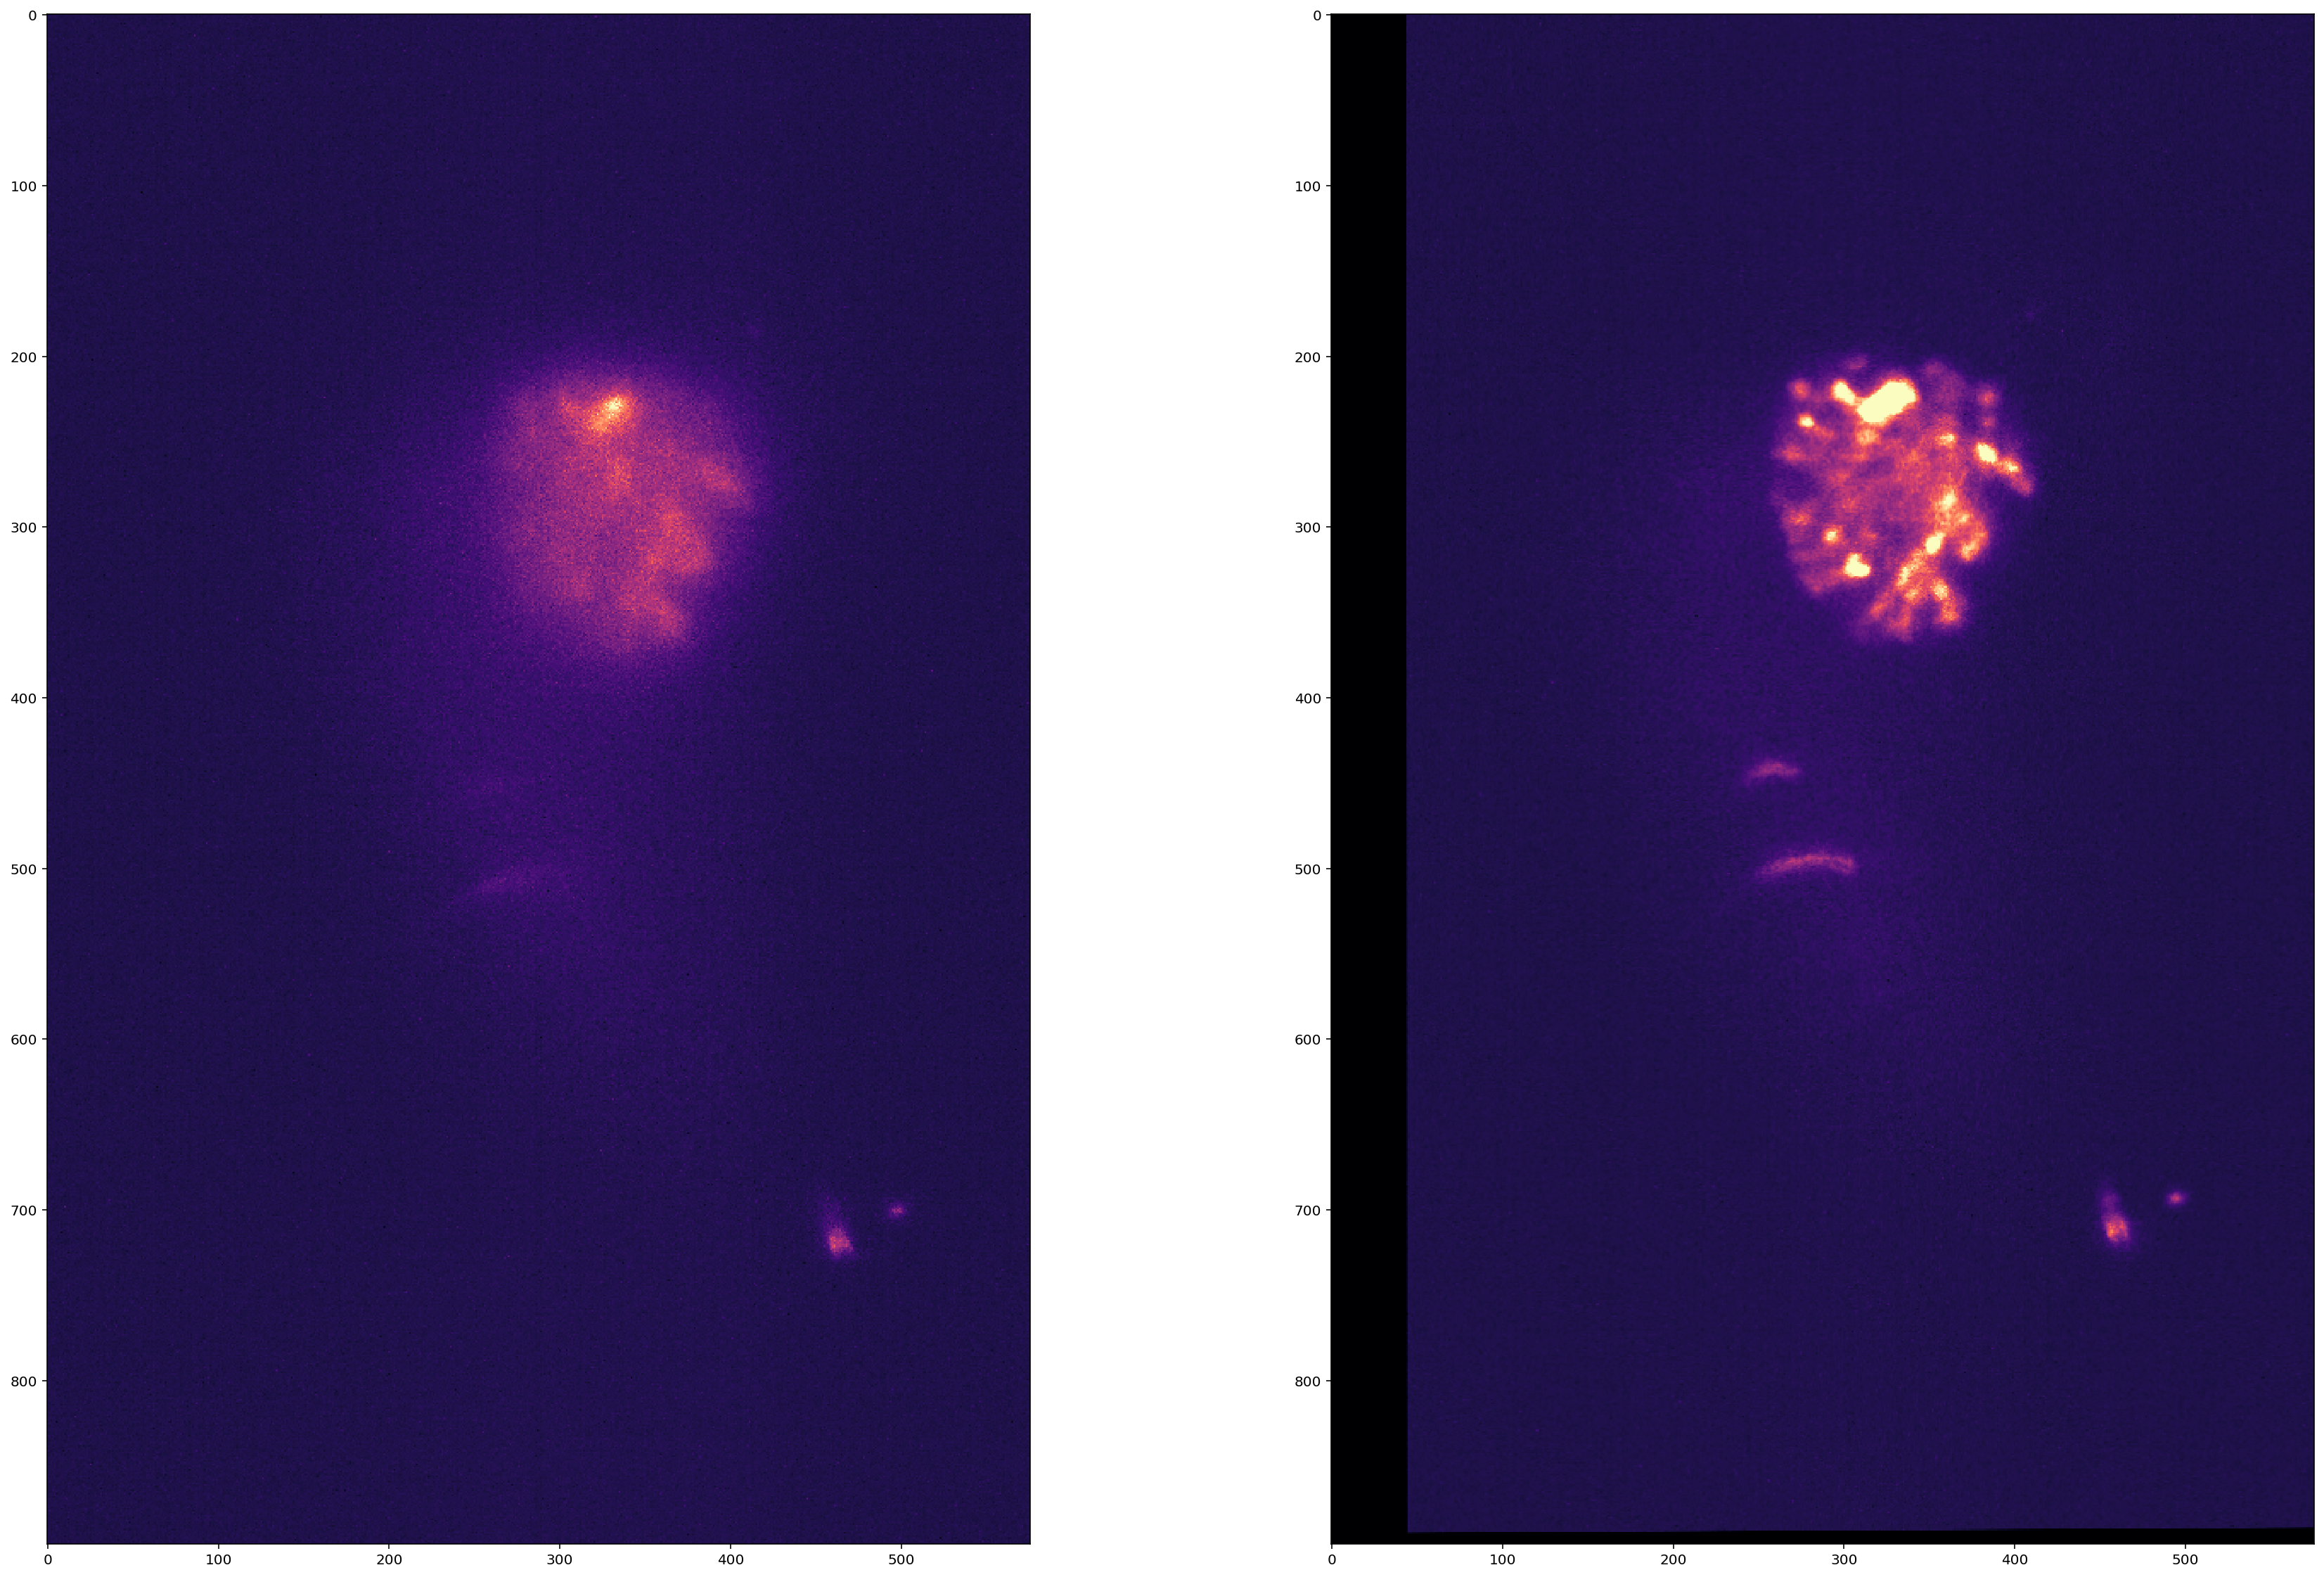

In [10]:
vmin=np.min(imgsX[14][5,...])
vmax=np.max(imgsX[14][5,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Since there is an artificial margin in the input and the output, we chop away the first and last 60 in the x dimension and in the y dimension

In [11]:
imgsX_chopped=[]
imgsY_chopped=[]
for i in range(len(imgsX)):
    imgsX_chopped.append(imgsX[i][:, 60:-60, 60:-60])
    imgsY_chopped.append(imgsY[i][:, 60:-60, 60:-60])

## Visualize the images again

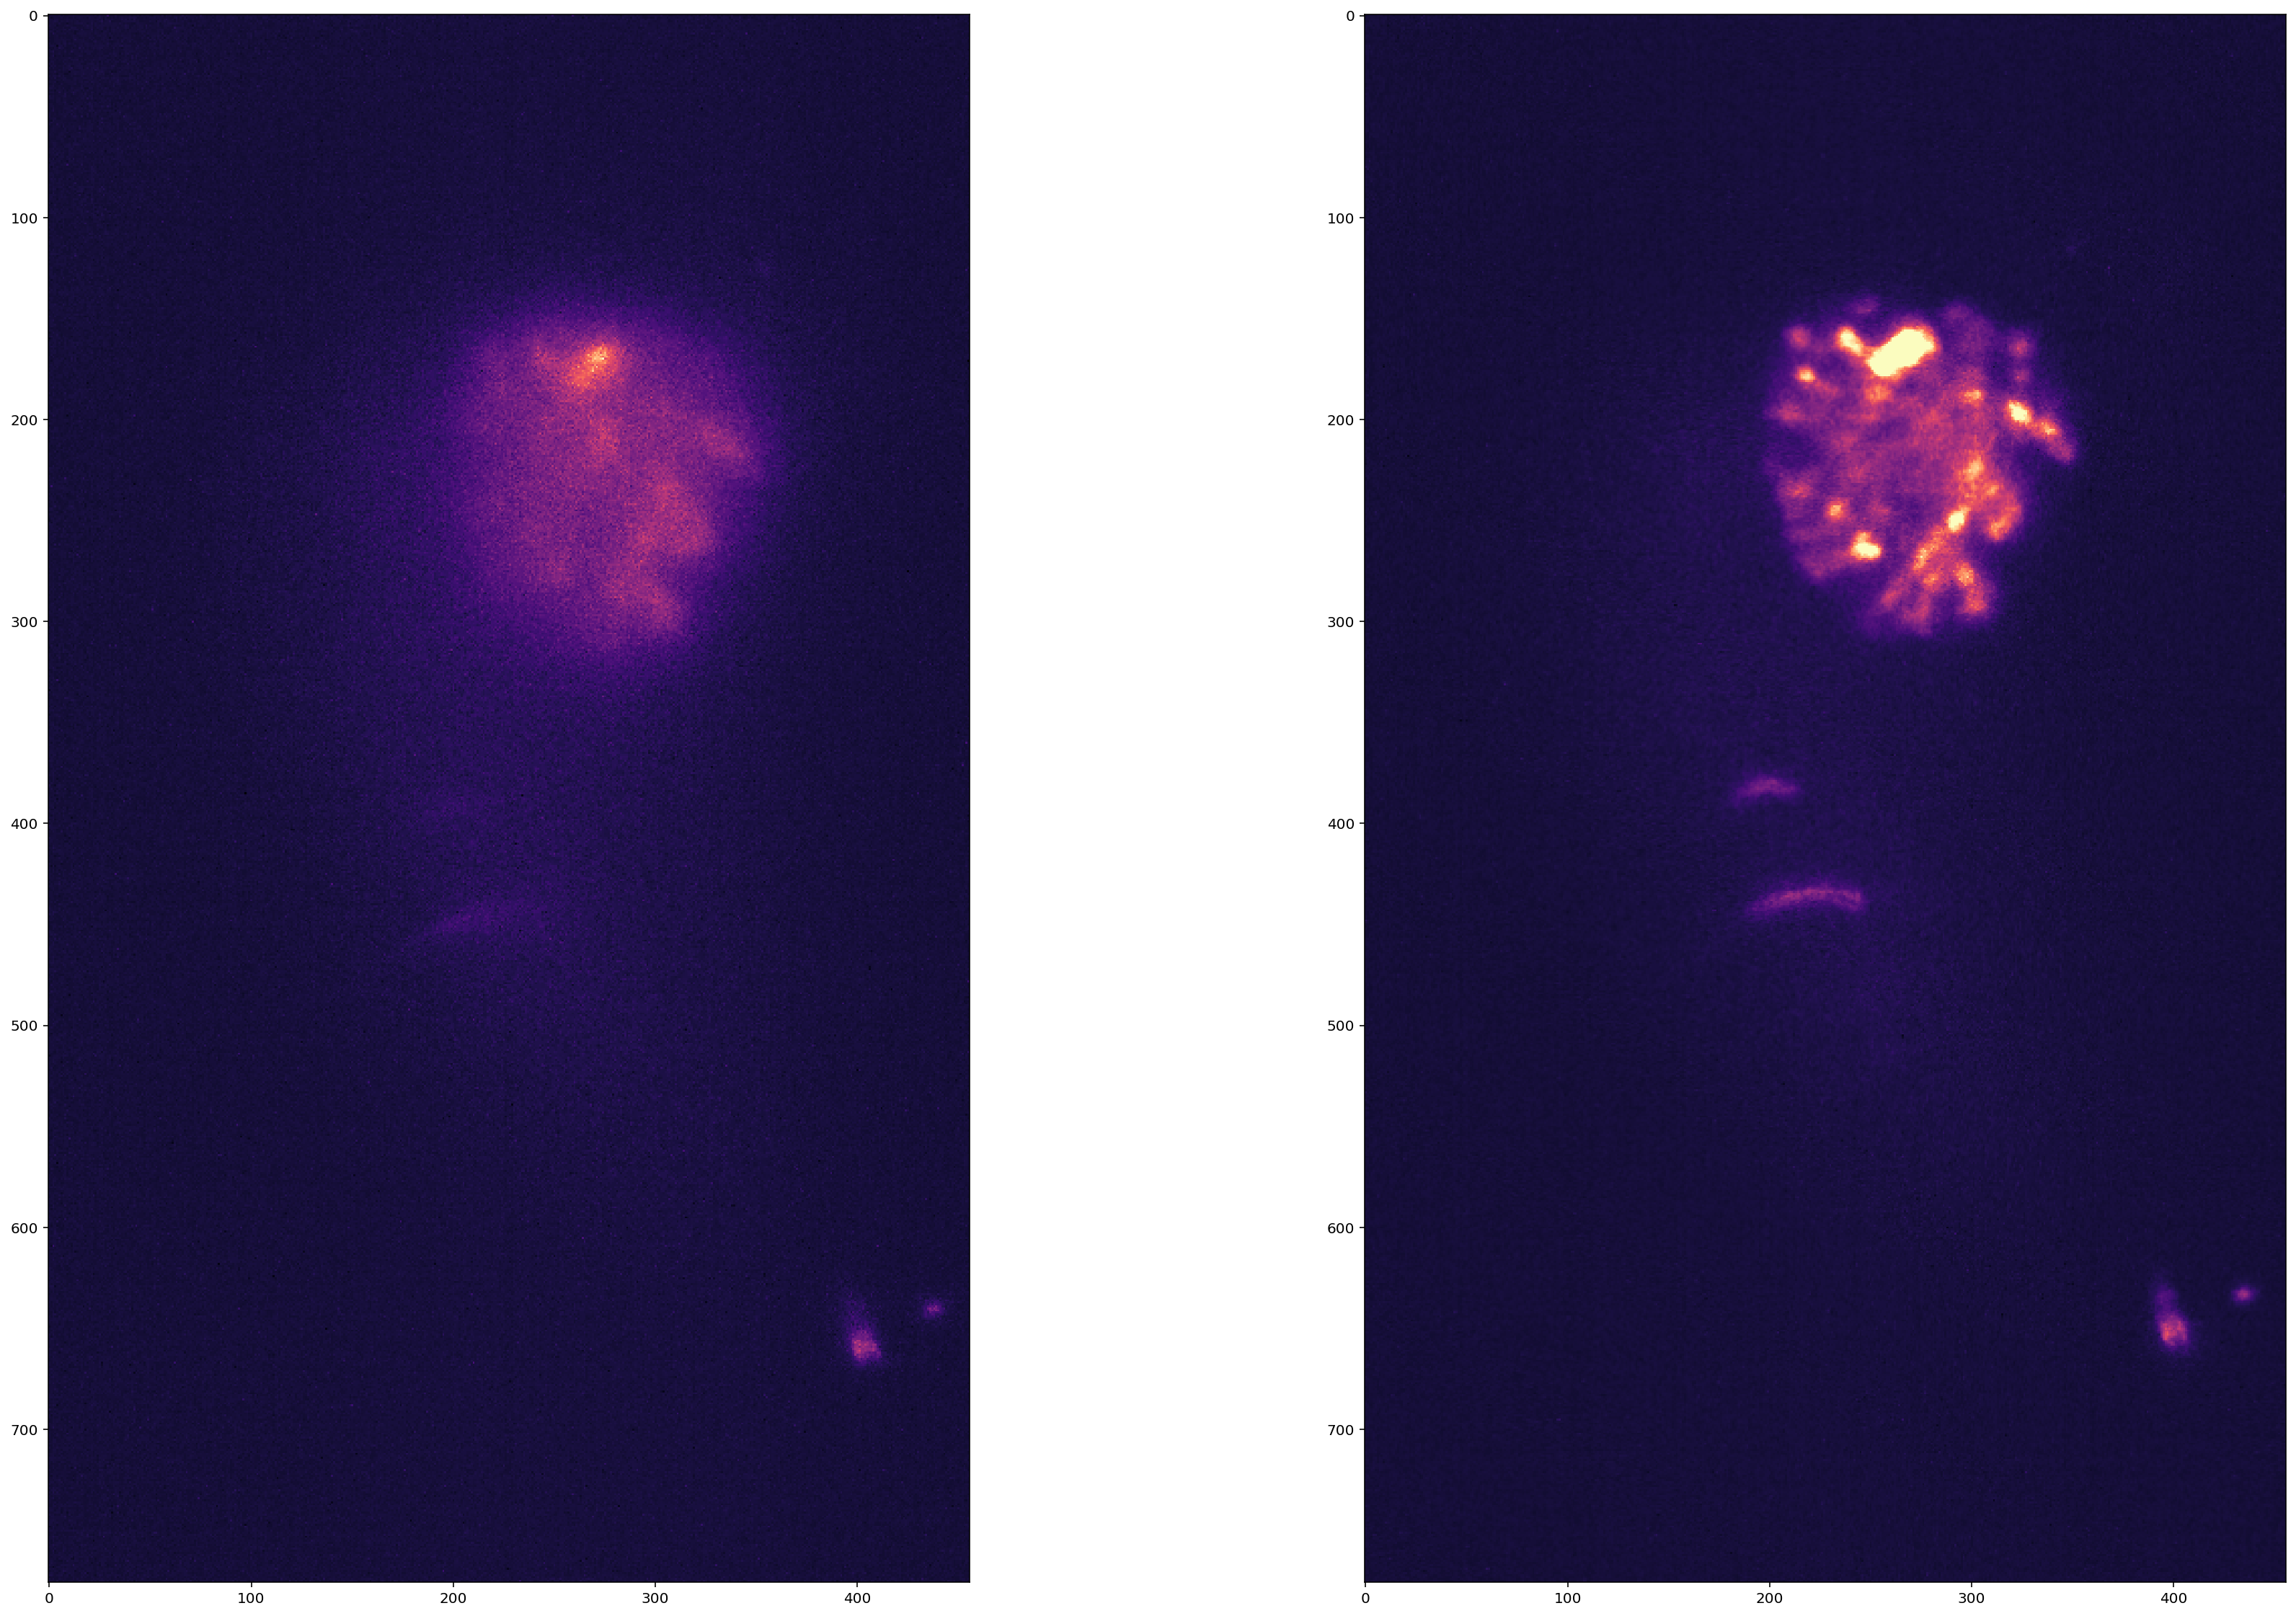

In [12]:
vmin=np.min(imgsX_chopped[15][5,...])
vmax=np.max(imgsX_chopped[15][5,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX_chopped[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY_chopped[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Also we must normalize the patches, prior to training !!

In [13]:
mean=np.mean(imgsX_chopped)
print(mean)
std=np.std(imgsX_chopped)
print(std)

109.82844187627575
21.346801061957


## Create patches

In [14]:
imgsX_chopped=np.concatenate(imgsX_chopped, axis=0)
print(imgsX_chopped.shape)
imgsY_chopped=np.concatenate(imgsY_chopped, axis=0)
print(imgsY_chopped.shape)

(140, 776, 456)
(140, 776, 456)


In [15]:
combined=np.empty([np.shape(imgsX_chopped)[0], np.shape(imgsX_chopped)[1], np.shape(imgsX_chopped)[2], 2])
combined[..., 0]=imgsX_chopped
combined[..., 1]=imgsY_chopped
# Normalization Step
combined=(combined-mean)/std
print(combined.dtype)

float64


In [16]:
combinedList=[]
combinedList.append(combined)
print(len(combinedList))

1


## Augment is set to True

In [17]:
datagen = N2V_DataGenerator()
patches = datagen.generate_patches_from_list(combinedList, shape=(96, 96), augment=True)
print(patches.shape)

Generated patches: (35840, 96, 96, 2)
(35840, 96, 96, 2)


## Create train and validation pairs

In [18]:
X=patches[:-1000,..., 0]
X=X[..., np.newaxis]
Y=patches[:-1000, ..., 1]
Y=Y[..., np.newaxis]
X_val=patches[-1000:,..., 0]
X_val=X_val[..., np.newaxis]
Y_val=patches[-1000:, ..., 1]
Y_val=Y_val[..., np.newaxis]
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

X shape:  (34840, 96, 96, 1)
Y shape:  (34840, 96, 96, 1)
X_val shape:  (1000, 96, 96, 1)
Y_val shape:  (1000, 96, 96, 1)


In [19]:
print("Datatype is:", patches[0, ..., 0].dtype)

Datatype is: float64


## Plot some examples from validation data

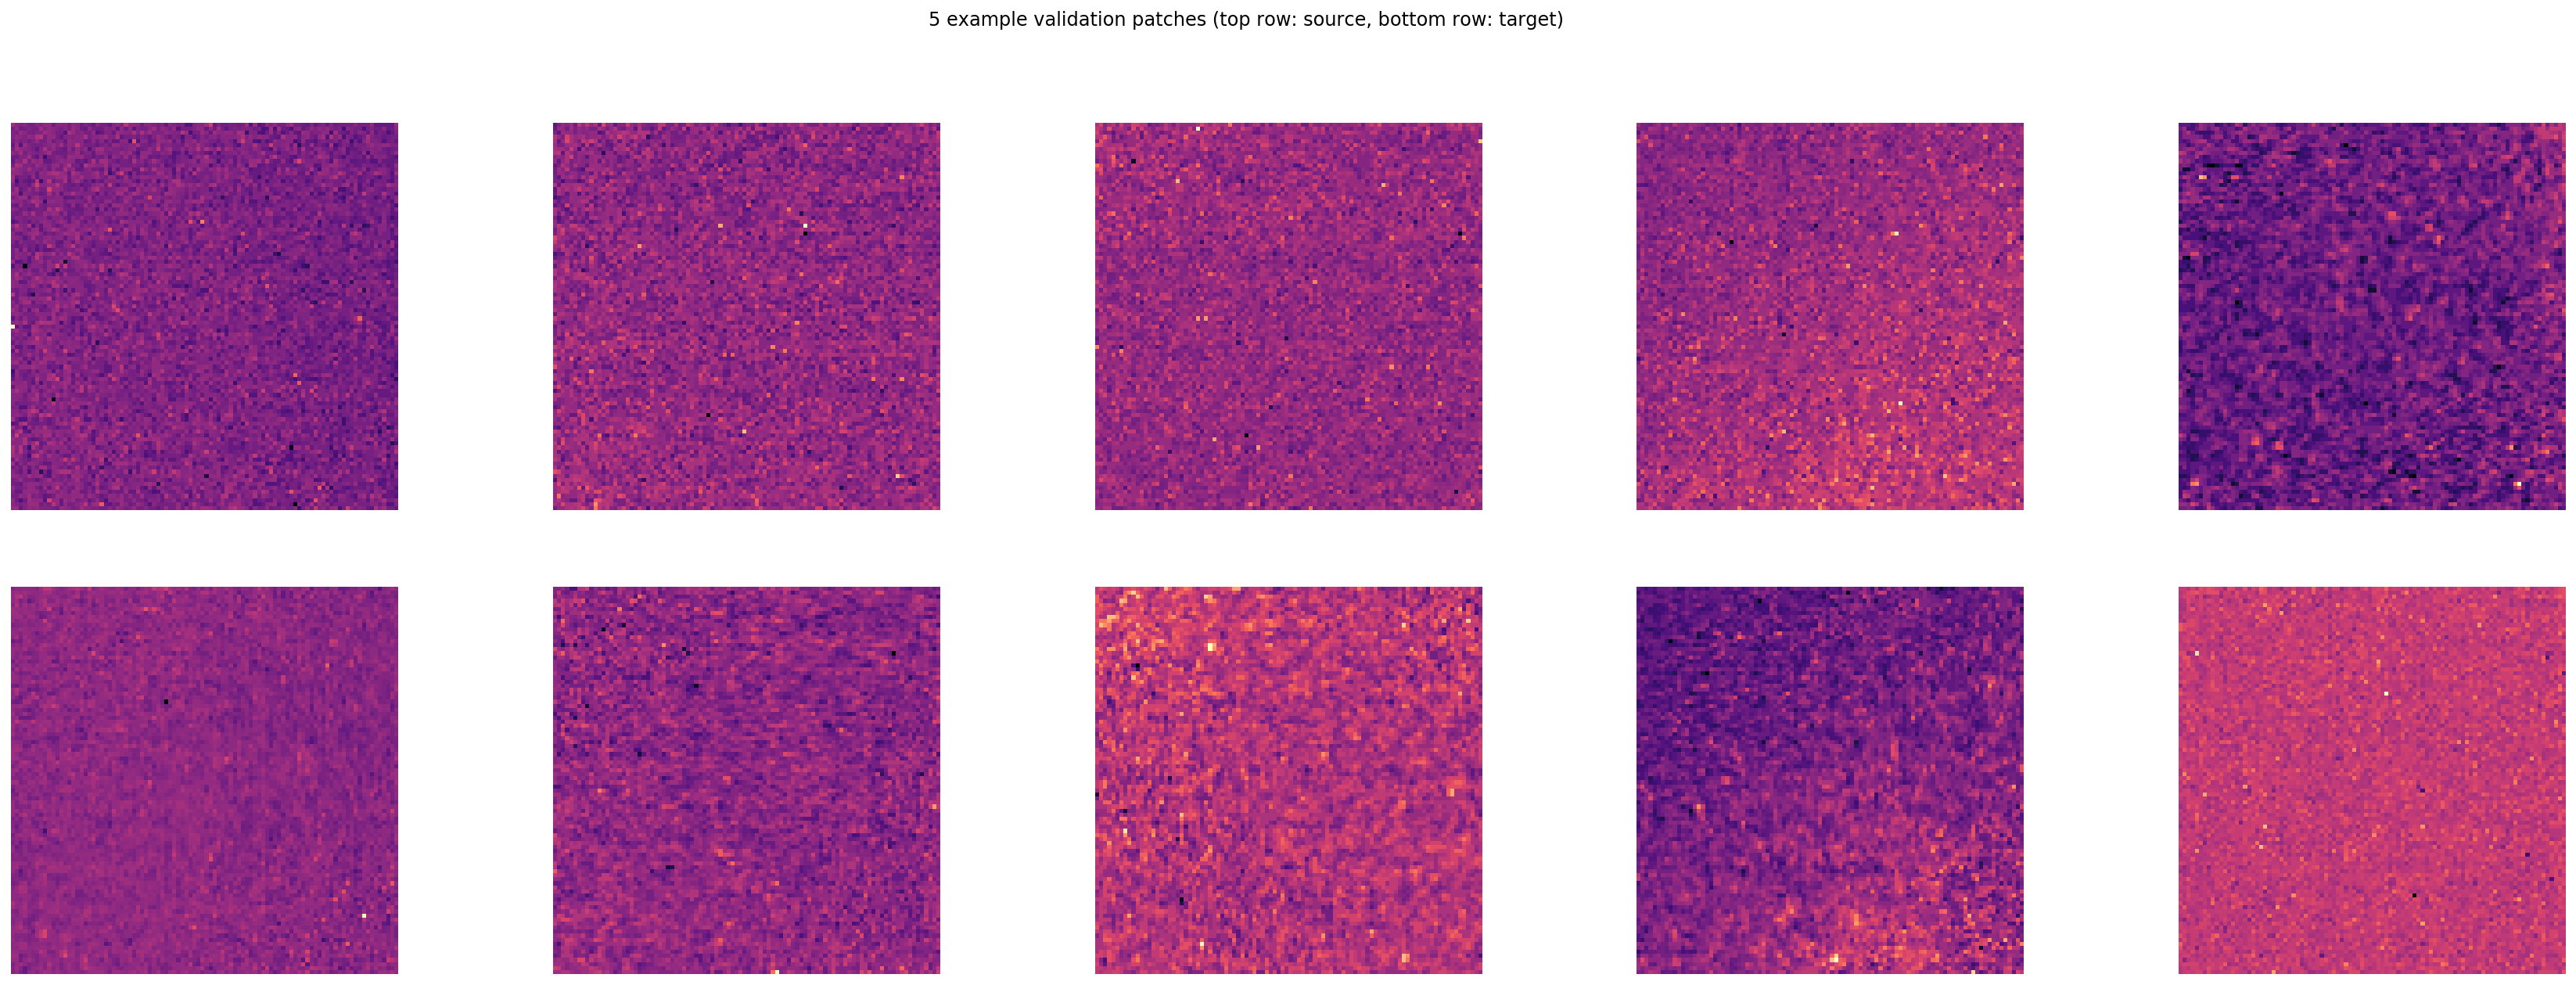

In [20]:
plt.figure(figsize=(30,10))
plot_some(X_val[300:305, ...],Y_val[300:305, ...])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [21]:
axes='SYXC'
n_channel_in=1
n_channel_out=1
config = Config(axes, n_channel_in, n_channel_out, probabilistic=False, train_steps_per_epoch=250, train_epochs=300, unet_n_first=64, unet_n_depth=3, unet_residual=False)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=300, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=250, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=64, unet_residual=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 5,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 300,
 'train_steps_per_epoch': 250,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [22]:
model = CARE(config, 'care_2D_kellerlab_with_normalization_with_HandRegistration_float64_Q1_ne_300_es_250', basedir='models')

In [23]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

/home/lalit/Desktop/02_SoftwareExecutables/anaconda3/envs/n2vmultiviewEnv/lib/python3.6/site-packages/csbdeep/models/care_standard.py:259: UserWarning: small number of validation images (only 2.8% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))


Epoch 1/300
250/250 [==============================] - 26s 104ms/step - loss: 0.2955 - mse: 0.8728 - mae: 0.2955 - val_loss: 0.2909 - val_mse: 0.7686 - val_mae: 0.2909
Epoch 2/300
250/250 [==============================] - 24s 95ms/step - loss: 0.2735 - mse: 0.7469 - mae: 0.2735 - val_loss: 0.2864 - val_mse: 0.7994 - val_mae: 0.2864
Epoch 3/300
250/250 [==============================] - 23s 94ms/step - loss: 0.2700 - mse: 0.7202 - mae: 0.2700 - val_loss: 0.2866 - val_mse: 0.7718 - val_mae: 0.2866
Epoch 4/300
250/250 [==============================] - 23s 94ms/step - loss: 0.2670 - mse: 0.6951 - mae: 0.2670 - val_loss: 0.2830 - val_mse: 0.7749 - val_mae: 0.2830
Epoch 5/300
250/250 [==============================] - 24s 94ms/step - loss: 0.2786 - mse: 0.7922 - mae: 0.2786 - val_loss: 0.2904 - val_mse: 0.8455 - val_mae: 0.2904
Epoch 6/300
250/250 [==============================] - 24s 96ms/step - loss: 0.2680 - mse: 0.7542 - mae: 0.2680 - val_loss: 0.2958 - val_mse: 0.8064 - val_mae: 0.29

Epoch 50/300
250/250 [==============================] - 24s 94ms/step - loss: 0.2266 - mse: 0.4431 - mae: 0.2266 - val_loss: 0.2432 - val_mse: 0.5396 - val_mae: 0.2432
Epoch 51/300
250/250 [==============================] - 24s 95ms/step - loss: 0.2321 - mse: 0.5055 - mae: 0.2321 - val_loss: 0.2465 - val_mse: 0.5283 - val_mae: 0.2465
Epoch 52/300
250/250 [==============================] - 23s 94ms/step - loss: 0.2284 - mse: 0.4963 - mae: 0.2284 - val_loss: 0.2419 - val_mse: 0.5053 - val_mae: 0.2419
Epoch 53/300
250/250 [==============================] - 24s 96ms/step - loss: 0.2211 - mse: 0.4550 - mae: 0.2211 - val_loss: 0.2438 - val_mse: 0.5349 - val_mae: 0.2438
Epoch 54/300
250/250 [==============================] - 24s 95ms/step - loss: 0.2181 - mse: 0.4740 - mae: 0.2181 - val_loss: 0.2376 - val_mse: 0.5083 - val_mae: 0.2376
Epoch 55/300
250/250 [==============================] - 24s 95ms/step - loss: 0.2297 - mse: 0.4768 - mae: 0.2297 - val_loss: 0.2370 - val_mse: 0.4969 - val_mae:

Epoch 99/300
250/250 [==============================] - 24s 96ms/step - loss: 0.2021 - mse: 0.3679 - mae: 0.2021 - val_loss: 0.2120 - val_mse: 0.3444 - val_mae: 0.2120
Epoch 100/300
250/250 [==============================] - 24s 96ms/step - loss: 0.2051 - mse: 0.3213 - mae: 0.2051 - val_loss: 0.2114 - val_mse: 0.3326 - val_mae: 0.2114
Epoch 101/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1999 - mse: 0.3321 - mae: 0.1999 - val_loss: 0.2147 - val_mse: 0.3471 - val_mae: 0.2147
Epoch 102/300
250/250 [==============================] - 24s 96ms/step - loss: 0.2084 - mse: 0.3424 - mae: 0.2084 - val_loss: 0.2131 - val_mse: 0.3322 - val_mae: 0.2131
Epoch 103/300
250/250 [==============================] - 24s 94ms/step - loss: 0.2079 - mse: 0.3404 - mae: 0.2079 - val_loss: 0.2122 - val_mse: 0.3354 - val_mae: 0.2122
Epoch 104/300
250/250 [==============================] - 24s 96ms/step - loss: 0.2076 - mse: 0.3629 - mae: 0.2076 - val_loss: 0.2150 - val_mse: 0.3617 - val

250/250 [==============================] - 24s 95ms/step - loss: 0.1918 - mse: 0.3209 - mae: 0.1918 - val_loss: 0.2042 - val_mse: 0.3033 - val_mae: 0.2042
Epoch 148/300
250/250 [==============================] - 24s 97ms/step - loss: 0.1933 - mse: 0.3216 - mae: 0.1933 - val_loss: 0.2059 - val_mse: 0.3086 - val_mae: 0.2059
Epoch 149/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1937 - mse: 0.2822 - mae: 0.1937 - val_loss: 0.2025 - val_mse: 0.2877 - val_mae: 0.2025
Epoch 150/300
250/250 [==============================] - 24s 96ms/step - loss: 0.1918 - mse: 0.2879 - mae: 0.1918 - val_loss: 0.2059 - val_mse: 0.2955 - val_mae: 0.2059
Epoch 151/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1938 - mse: 0.3028 - mae: 0.1938 - val_loss: 0.2021 - val_mse: 0.2914 - val_mae: 0.2021
Epoch 152/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1846 - mse: 0.2298 - mae: 0.1846 - val_loss: 0.2041 - val_mse: 0.2942 - val_mae: 0.2041


250/250 [==============================] - 24s 97ms/step - loss: 0.1880 - mse: 0.2908 - mae: 0.1880 - val_loss: 0.1972 - val_mse: 0.2700 - val_mae: 0.1972
Epoch 196/300
250/250 [==============================] - 24s 96ms/step - loss: 0.1921 - mse: 0.2894 - mae: 0.1921 - val_loss: 0.1983 - val_mse: 0.2751 - val_mae: 0.1983
Epoch 197/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1824 - mse: 0.2625 - mae: 0.1824 - val_loss: 0.2074 - val_mse: 0.3258 - val_mae: 0.2074
Epoch 198/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1849 - mse: 0.2542 - mae: 0.1849 - val_loss: 0.1981 - val_mse: 0.2792 - val_mae: 0.1981
Epoch 199/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1797 - mse: 0.2121 - mae: 0.1797 - val_loss: 0.2012 - val_mse: 0.2904 - val_mae: 0.2012
Epoch 200/300
250/250 [==============================] - 24s 96ms/step - loss: 0.1898 - mse: 0.2897 - mae: 0.1898 - val_loss: 0.1981 - val_mse: 0.2860 - val_mae: 0.1981


250/250 [==============================] - 24s 94ms/step - loss: 0.1718 - mse: 0.2027 - mae: 0.1718 - val_loss: 0.1902 - val_mse: 0.2532 - val_mae: 0.1902
Epoch 244/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1743 - mse: 0.2097 - mae: 0.1743 - val_loss: 0.1904 - val_mse: 0.2565 - val_mae: 0.1904
Epoch 245/300
250/250 [==============================] - 24s 96ms/step - loss: 0.1805 - mse: 0.2458 - mae: 0.1805 - val_loss: 0.1909 - val_mse: 0.2520 - val_mae: 0.1909
Epoch 246/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1782 - mse: 0.2343 - mae: 0.1782 - val_loss: 0.1916 - val_mse: 0.2506 - val_mae: 0.1916
Epoch 247/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1739 - mse: 0.1983 - mae: 0.1739 - val_loss: 0.1898 - val_mse: 0.2506 - val_mae: 0.1898
Epoch 248/300
250/250 [==============================] - 24s 96ms/step - loss: 0.1748 - mse: 0.2387 - mae: 0.1748 - val_loss: 0.1954 - val_mse: 0.2568 - val_mae: 0.1954


250/250 [==============================] - 24s 96ms/step - loss: 0.1671 - mse: 0.1936 - mae: 0.1671 - val_loss: 0.1867 - val_mse: 0.2393 - val_mae: 0.1867
Epoch 291/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1722 - mse: 0.2145 - mae: 0.1722 - val_loss: 0.1869 - val_mse: 0.2387 - val_mae: 0.1869
Epoch 292/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1693 - mse: 0.2251 - mae: 0.1693 - val_loss: 0.1867 - val_mse: 0.2405 - val_mae: 0.1867
Epoch 293/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1689 - mse: 0.1985 - mae: 0.1689 - val_loss: 0.1866 - val_mse: 0.2380 - val_mae: 0.1866
Epoch 294/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1671 - mse: 0.2092 - mae: 0.1671 - val_loss: 0.1865 - val_mse: 0.2383 - val_mae: 0.1865
Epoch 295/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1682 - mse: 0.1855 - mae: 0.1682 - val_loss: 0.1870 - val_mse: 0.2376 - val_mae: 0.1870


['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


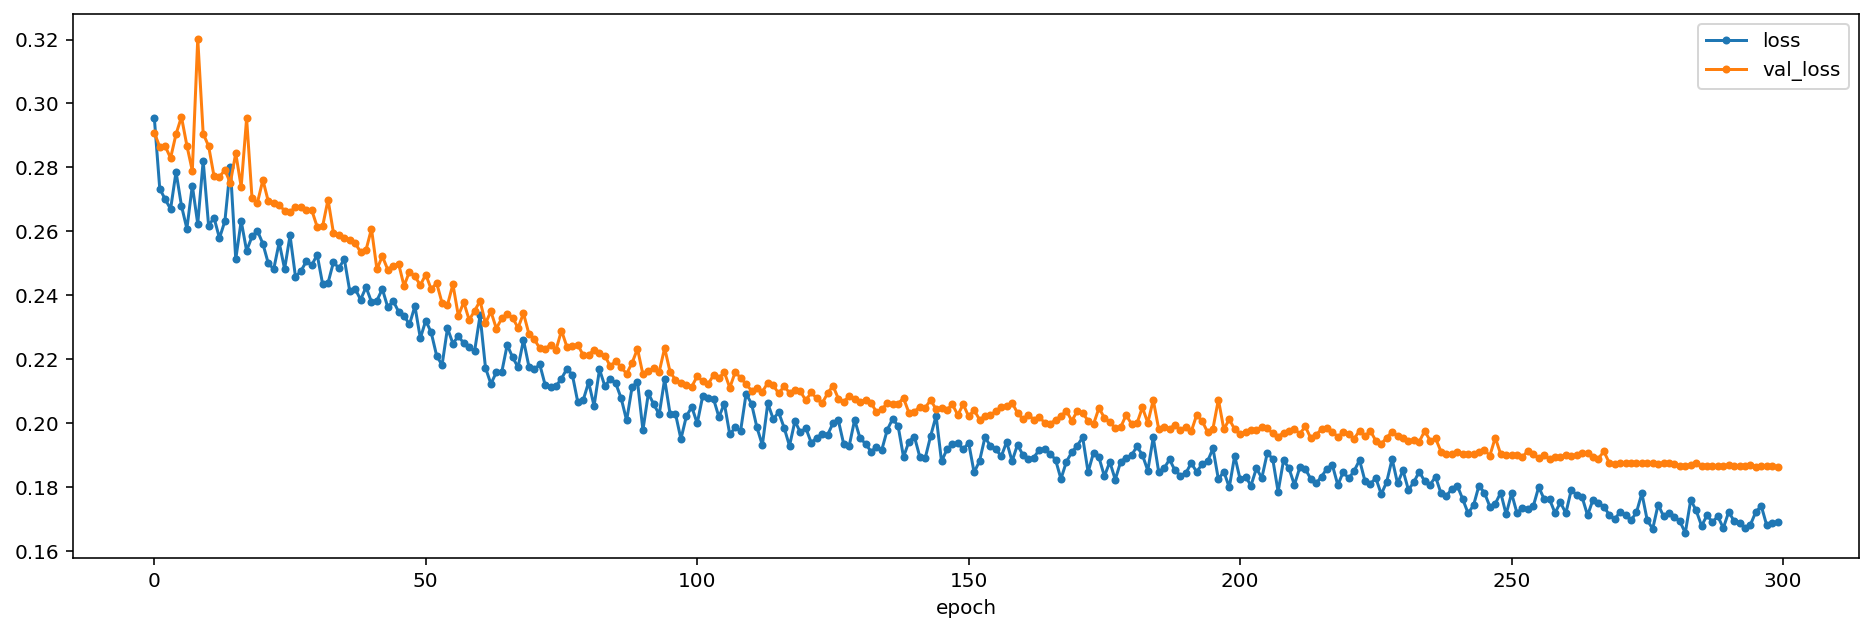

In [24]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);